<a href="https://colab.research.google.com/github/nicholassolomon/DBourke_PyTorch/blob/main/PyTorch_using_ResNet_Model_for_Transfer_Learning_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch YT Bourke

Take what was learned in the 0-7 videos, docs and notebooks, and do the following challenge:

1. Select ResNet model for transfer learning.
2. Import the smaller Sushi/Steak/Pizza dataset and build dataloaders.
3. Modify the model -- re-do classifier.
4. Set up experiment tracking using TensorBoard.
5. Run experiments using the model making changes:
 * 5, 10 and 100 epochs
 * chaning learning rate from 1e-1 to 1e-3
6. Determine the best training hyperparameters.
7. Use the best model to predict some sample images from the dataset and display the results in the notebook.

```
01.22.24:  start
```

## 1.0 Setup Code and Data

In [ ]:
import torch
import torchvision

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    import torchinfo
    from torchinfo import summary

print(f"Torch: {torch.__version__}") # want 2.1+
print(f"Torchvision: {torchvision.__version__}") # want 0.16+
print(f"Torchinfo: {torchinfo.__version__}")

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

## 1.1 Get Data

* `\data\pizza_steak_sushi\test`
* `\data\pizza_steak_sushi\train`


In [ ]:
import os
import zipfile

from pathlib import Path

import requests

#zipfile = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get('https://github.com/nicholassolomon/DBourke_PyTorch/raw/main/data/pizza_steak_sushi.zip')
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

## 1.2 Get Code

In [ ]:
# code imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    #!git clone https://github.com/mrdbourke/pytorch-deep-learning
    !git clone https://github.com/nicholassolomon/DBourke_PyTorch
    !mv DBourke_PyTorch/going_modular .
    !rm -rf DBourke_PyTorch
#    from going_modular.going_modular import data_setup, engine

## 1.3 Model and Transforms for ResNet50

In [ ]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

In [ ]:
from torchvision.models import ResNet50_Weights, resnet50
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

resnet50(weights=ResNet50_Weights.DEFAULT)
model = resnet50(weights="DEFAULT")
model

In [ ]:
weights = torchvision.models.ResNet50_Weights.DEFAULT # "DEFAULT" = best available weights

auto_transforms = weights.transforms()
auto_transforms

## 1.4 DataLoaders

In [ ]:
from going_modular import data_setup
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

## 1.5 Freeze Layers and Modify Classifier Layer

> Indented block



1. set all to false
```
for param in model.parameters():
  param.requires_grad = False
```
2. set last to true
```
for param in model.fc.parameters():
  param.requires_grad = True
```    


In [ ]:
for param in model.parameters():
  param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad = True

In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=len(class_names), bias=True)
#fc): Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 232, 232), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

## 2.0 Train Model

In [46]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [48]:
# Import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0612 | train_acc: 0.5000 | test_loss: 1.0266 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8646 | train_acc: 0.7109 | test_loss: 0.9162 | test_acc: 0.6714
Epoch: 3 | train_loss: 0.7595 | train_acc: 0.8555 | test_loss: 0.8139 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.6714 | train_acc: 0.9102 | test_loss: 0.7389 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.8203 | test_loss: 0.7168 | test_acc: 0.8665
[INFO] Total training time: 544.383 seconds


## 3.0 Evaluate Model

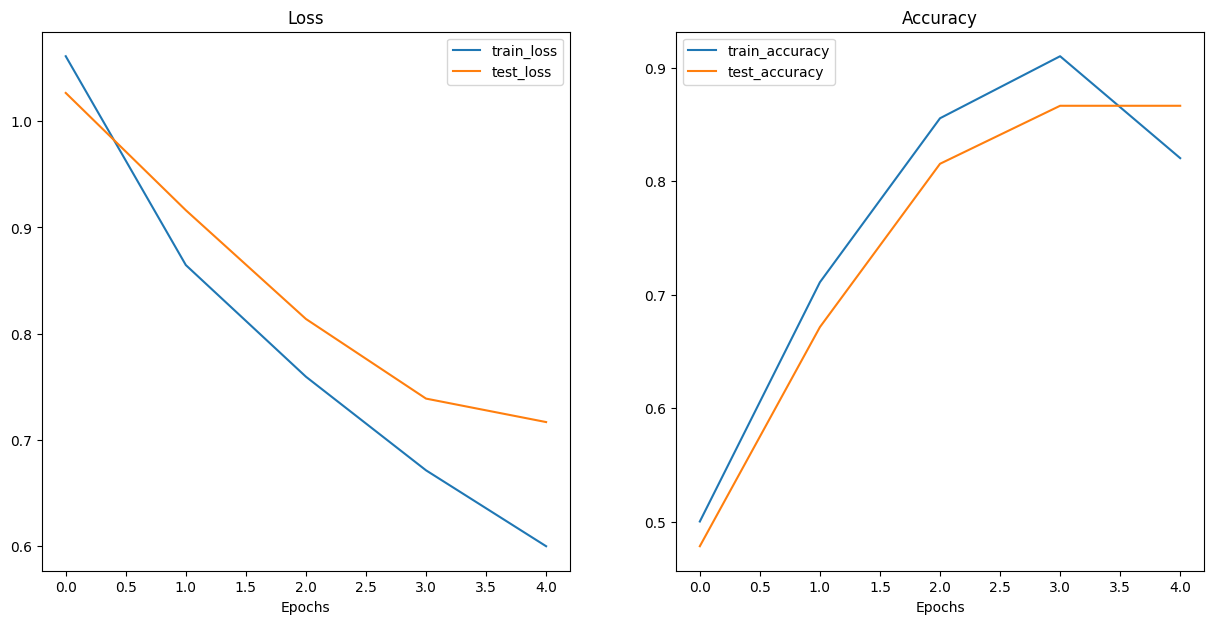

In [49]:
from going_modular import helper_functions

# Plot the loss curves of our model
helper_functions.plot_loss_curves(results)

## 4.0 Make predictions on images from the test set

In [50]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (232, 232),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # print(target_image_pred_probs.max())

  # 9. Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

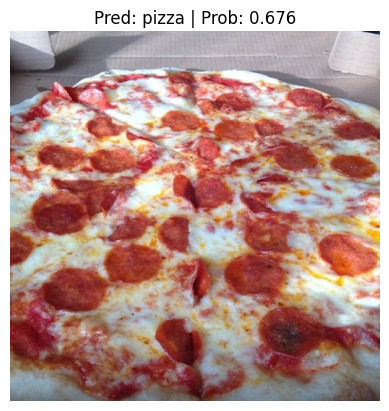

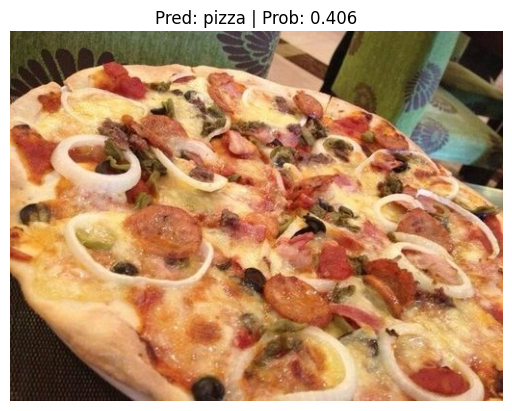

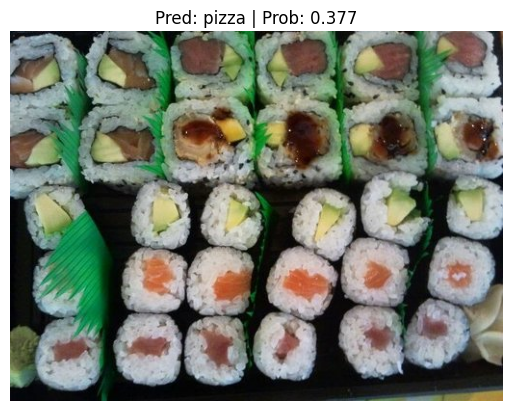

In [51]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(232, 232))